# 03 — scikit-learn Basics
*A practical tour of classical ML with scikit-learn — datasets, preprocessing, models, metrics, and pipelines.*

**What you'll learn**
- The **scikit-learn API**: `fit`, `predict`, `score`
- Loading & splitting datasets, **preprocessing** (scaling, one-hot), **pipelines**
- Core models: **LinearRegression**, **LogisticRegression**, **SVC**, **RandomForest**
- **Model selection** via cross-validation & grid search
- Clear plots for diagnostics and evaluation

> Before deep RL, we need strong ML hygiene — splitting data, avoiding leakage, and using robust metrics. These practices transfer directly to training value functions and reward models.

In [7]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_squared_error, r2_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
)

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.decomposition import PCA

np.random.seed(0)

## 1. Quick API Primer

The **scikit-learn API** is designed with a consistent and minimal interface that makes experimenting with models simple and reproducible.  
Almost every algorithm in scikit-learn follows this pattern:

1. `est = Model(**hyperparams)` → **Initialize** the estimator with parameters.  
2. `est.fit(X_train, y_train)` → **Train** (learn parameters from data).  
3. `pred = est.predict(X_test)` → **Infer** on unseen data.  
4. `score = est.score(X_test, y_test)` → **Evaluate** using an appropriate metric.


### Theoretical Insight

In supervised learning, we model the mapping  
$$
\hat{y} = f_\theta(x)
$$
where $ f_\theta $ is parameterized by $\theta$ (weights, coefficients, etc.).  
Training minimizes an empirical risk:
$$
\min_\theta \; \mathcal{L}(\theta) = \frac{1}{N} \sum_{i=1}^{N} \ell(f_\theta(x_i), y_i)
$$
Here, $\ell$ is a **loss function**, e.g. mean squared error or cross-entropy.  
Different estimators implement this optimization internally — linear models solve it analytically, while trees or ensembles do it iteratively.

The design philosophy of scikit-learn enforces:
- **Consistency**: same API for classification, regression, clustering, etc.
- **Composability**: estimators, transformers, and pipelines can be chained.
- **Statelessness**: fit-transform steps are explicit, avoiding hidden state.


### RL Connection

In **Reinforcement Learning**, we often optimize models that map states to actions or predict values/rewards.  
Just like `fit` learns patterns from labeled data, an RL agent **fits** policy parameters to maximize expected return:
$$
J(\theta) = \mathbb{E}_{\pi_\theta} \big[ \sum_t \gamma^t r_t \big]
$$
Conceptually:
- The policy $ \pi_\theta(a|s) $ plays the role of $ f_\theta(x) $.
- Gradient-based updates in RL (e.g., Policy Gradient, Q-learning) are analogous to scikit-learn’s internal optimization loops.
- Building pipelines and evaluating models (like in scikit-learn) mirrors how we test and tune agents across environments.

> Understanding the fit–predict–evaluate loop prepares you for the **optimize–interact–evaluate** loop in RL.

## 2. Regression — Linear Regression on Diabetes

Regression is a fundamental supervised learning task where the goal is to predict a **continuous target variable** $ y $ from input features $ x $. The simplest and most interpretable model is **Linear Regression**, which assumes a linear relationship:

$$
\hat{y} = w^\top x + b
$$

Here:
- $ w $ are the **weights** (slope coefficients),
- $ b $ is the **bias** (intercept),
- $ \hat{y} $ is the model’s prediction for input $ x $.


### Mathematical Formulation

Given data $ (x_i, y_i)_{i=1}^N $, we minimize the **Mean Squared Error (MSE)**:

$$
\mathcal{L}(w, b) = \frac{1}{N} \sum_{i=1}^{N} (y_i - (w^\top x_i + b))^2
$$

This has a **closed-form solution** (Normal Equation):

$$
\hat{w} = (X^\top X)^{-1} X^\top y
$$

Linear regression thus finds the best-fitting line (or hyperplane) that minimizes the squared residuals between predictions and true values.


### Interpretation & Visualization

When applied to the **Diabetes dataset**, we model how medical metrics (e.g., BMI, glucose level) affect disease progression scores.  
By plotting predicted vs. actual values, we can visually assess:
- **Fit quality:** how close predictions align with targets.
- **Bias/variance:** systematic errors or noise sensitivity.


### RL Connection

Linear regression directly relates to **value function approximation** in Reinforcement Learning.  
For instance, in **Least Squares Temporal Difference (LSTD)** methods, the value function is approximated as:

$$
V^\pi(s) \approx \phi(s)^\top w
$$

where $ \phi(s) $ are **state features** and $ w $ is found by minimizing the temporal difference error — analogous to minimizing MSE in regression.

Thus, understanding linear regression lays the groundwork for:
- **Linear value approximation** (in TD or LSTD),
- **Policy evaluation** under fixed policies,
- **Function approximation stability** and convergence properties.

Mean Squared Error (MSE): 2848.311
R² Score: 0.485


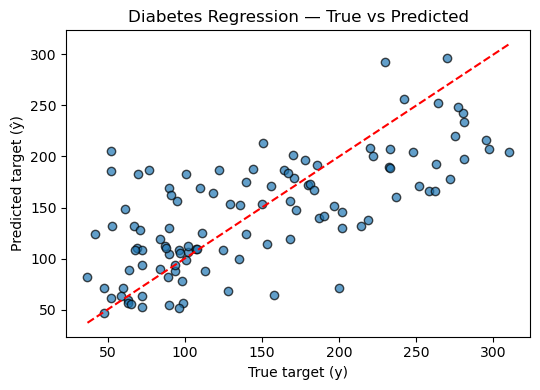

In [ ]:
# Load dataset
X, y = datasets.load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Build pipeline: scaling + linear regression
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", LinearRegression())
])

# Fit model
pipe.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipe.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"R² Score: {r2:.3f}")

# True vs. Predicted (Parity Plot)
plt.figure(figsize=(5.5, 4))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolor="k")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Diabetes Regression — True vs Predicted")
plt.xlabel("True target (y)")
plt.ylabel("Predicted target (ŷ)")
plt.tight_layout()
plt.show()

## 3. Classification — Logistic Regression on Iris

Classification is a **supervised learning** task where the goal is to assign an input $ x $ to one of several **discrete categories**. Unlike regression (which predicts continuous values), classification outputs probabilities over classes.


### Intuition

Despite its name, **Logistic Regression** is a **linear classifier**, not a regression model. It models the **log-odds** of a class being true as a linear function of inputs:

$$
\log \frac{P(y=1|x)}{1 - P(y=1|x)} = w^\top x + b
$$

Solving for probability gives the **sigmoid form**:

$$
P(y=1|x) = \sigma(w^\top x + b) = \frac{1}{1 + e^{-(w^\top x + b)}}
$$

For multi-class problems (like the **Iris dataset**), logistic regression generalizes via the **softmax function**:

$$
P(y=k|x) = \frac{e^{w_k^\top x}}{\sum_{j} e^{w_j^\top x}}
$$

The model is trained by minimizing the **cross-entropy loss**:

$$
\mathcal{L}(w) = -\frac{1}{N} \sum_{i=1}^N \sum_{k} y_{ik} \log P(y_i=k|x_i)
$$


### Evaluation

We typically assess classification performance via:
- **Accuracy:** fraction of correctly predicted labels.
- **Confusion matrix:** summarizes how often each class was predicted vs. true.
- **Precision/Recall/F1:** more nuanced metrics for imbalanced data.

For the **Iris dataset**, logistic regression learns a linear boundary in feature space separating species (e.g., *setosa*, *versicolor*, *virginica*).


### RL Connection

In **Reinforcement Learning**, many problems involve **classification-like decision boundaries**:
- **Discrete action policies:** modeled using softmax over action preferences  
  $$
  \pi(a|s) = \frac{e^{\theta_a^\top \phi(s)}}{\sum_b e^{\theta_b^\top \phi(s)}}
  $$
  — identical to multiclass logistic regression.
- **Policy gradient** algorithms update parameters based on log-probability gradients, just like logistic regression’s log-likelihood derivatives.
- **Exploration vs. exploitation** emerges naturally via probabilistic action sampling from these softmax outputs.

Thus, logistic regression forms the **conceptual bridge** between supervised learning and **stochastic policy optimization** in RL.

Accuracy: 0.9211

Classification report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        12
           1     0.8571    0.9231    0.8889        13
           2     0.9167    0.8462    0.8800        13

    accuracy                         0.9211        38
   macro avg     0.9246    0.9231    0.9230        38
weighted avg     0.9226    0.9211    0.9209        38



/opt/miniconda3/envs/rlfs/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


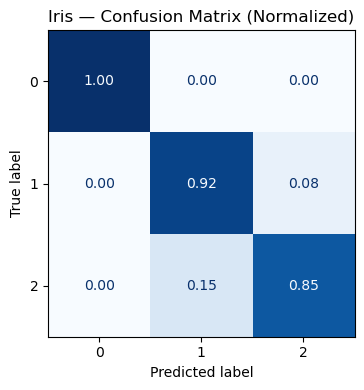

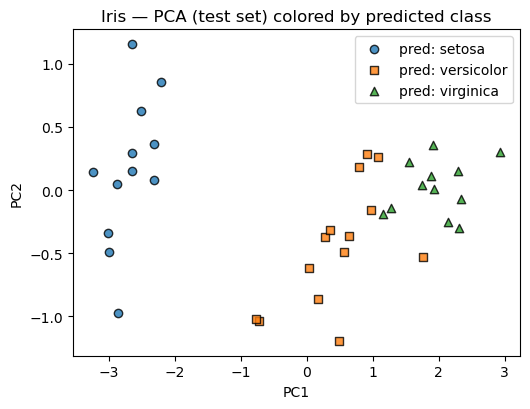

In [6]:
# Load & split (stratify preserves class balance in the split)
X, y = datasets.load_iris(return_X_y=True)
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# Pipeline: standardize → logistic regression (multinomial by default in sklearn >= 1.2)
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=500, multi_class="auto"))
])

# Train
clf.fit(X_tr, y_tr)

# Predict
y_hat = clf.predict(X_te)
y_proba = clf.predict_proba(X_te)

# Metrics
acc = accuracy_score(y_te, y_hat)
print(f"Accuracy: {acc:.4f}")
print("\nClassification report:")
print(classification_report(y_te, y_hat, digits=4))

# Confusion matrix (normalized)
cm = confusion_matrix(y_te, y_hat, labels=clf.classes_, normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
fig, ax = plt.subplots(figsize=(4.8, 4.0))
disp.plot(ax=ax, colorbar=False, cmap="Blues", values_format=".2f")
ax.set_title("Iris — Confusion Matrix (Normalized)")
plt.tight_layout()
plt.show()

# 2D view: PCA projection with predicted labels
# This gives intuition, though the original data are 4D.
pca = PCA(n_components=2).fit(X_tr) # fit PCA on training only
X_te_2d = pca.transform(X_te)

plt.figure(figsize=(5.4, 4.2))
for k, name, marker in zip([0,1,2], ["setosa", "versicolor", "virginica"], ["o","s","^"]):
    idx = (y_hat == k)
    plt.scatter(X_te_2d[idx, 0], X_te_2d[idx, 1], alpha=0.8, label=f"pred: {name}", marker=marker, edgecolor="k")

plt.title("Iris — PCA (test set) colored by predicted class")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend(frameon=True)
plt.tight_layout()
plt.show()

## 4. Model Selection — SVC with GridSearchCV

In machine learning, **model selection** ensures we choose the best hyperparameters for generalization rather than just fitting the training data.

A **Support Vector Classifier (SVC)** finds a separating hyperplane that maximizes the **margin** between classes:

$$
\min_{w,b} \frac{1}{2}\|w\|^2 \quad \text{s.t.} \quad y_i(w^\top x_i + b) \ge 1
$$

The optimization is controlled by two key hyperparameters:
- $ C $: regularization strength — smaller $C$ allows more margin violations (simpler model).  
- $ \gamma $: kernel coefficient in the RBF kernel $ K(x_i, x_j) = \exp(-\gamma \|x_i - x_j\|^2) $, controlling smoothness.


### Grid Search & Cross-Validation

`GridSearchCV` systematically explores hyperparameter combinations, training and validating each one via **cross-validation (CV)**.

For example:
- Split data into *k* folds.  
- Train on *k−1* folds, validate on the remaining fold.  
- Repeat *k* times and average the scores.

The model achieving the best mean CV score becomes the final estimator.

Mathematically, we select:
$$
\theta^* = \arg\max_\theta \frac{1}{K}\sum_{k=1}^K \text{Acc}_k(\theta)
$$


### In Practice

In scikit-learn, this looks like:

```python
GridSearchCV(estimator=SVC(), param_grid={"C":[0.1,1,10], "gamma":[0.01,0.1,1]}, cv=5)
```

The result object stores:
- `best_params_`: best hyperparameter combination
- `best_estimator_`: refitted final model
- `cv_results_`: detailed validation scores


### RL Connection

In Reinforcement Learning, hyperparameter tuning plays a similarly crucial role:

- Learning rates ($\eta$), discount factors ($\gamma$), and entropy coefficients affect stability.
- Methods like **policy search** or **meta-learning** can be seen as continuous analogues of grid search.
- In deep RL, adaptive search (like **Population-Based Training**) acts as a scalable form of hyperparameter optimization.

Best params: {'svc__C': 10, 'svc__gamma': 0.003, 'svc__kernel': 'rbf'}
Best CV score: 0.9852
Test accuracy: 0.9822

Classification Report (test):
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        45
           1     0.9574    0.9783    0.9677        46
           2     0.9778    1.0000    0.9888        44
           3     0.9783    0.9783    0.9783        46
           4     0.9778    0.9778    0.9778        45
           5     0.9787    1.0000    0.9892        46
           6     0.9778    0.9778    0.9778        45
           7     1.0000    1.0000    1.0000        45
           8     0.9762    0.9535    0.9647        43
           9     1.0000    0.9556    0.9773        45

    accuracy                         0.9822       450
   macro avg     0.9824    0.9821    0.9822       450
weighted avg     0.9824    0.9822    0.9822       450



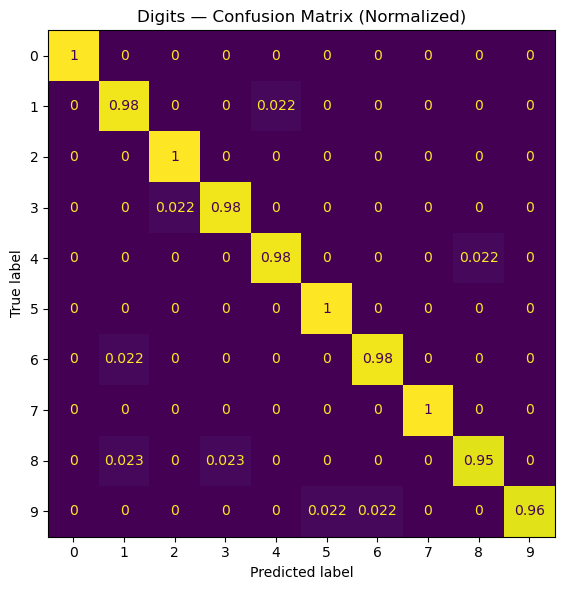


Top 5 CV configs:
  mean=0.9852±0.0066  |  {'svc__C': 10, 'svc__gamma': 0.003, 'svc__kernel': 'rbf'}
  mean=0.9829±0.0038  |  {'svc__C': 3, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
  mean=0.9822±0.0044  |  {'svc__C': 10, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
  mean=0.9814±0.0041  |  {'svc__C': 1, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
  mean=0.9800±0.0030  |  {'svc__C': 3, 'svc__gamma': 0.003, 'svc__kernel': 'rbf'}


In [9]:
# 1) Data split (stratified)
X, y = datasets.load_digits(return_X_y=True)
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=0
)

# 2) Pipeline: scale -> SVC
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC())
])

# 3) Hyperparameter grid (wider, log-spaced C; include 'scale' and numeric gammas)
param_grid = {
    "svc__kernel": ["rbf"],
    "svc__C": [0.1, 1, 3, 10],
    "svc__gamma": ["scale", 0.01, 0.003, 0.001],
}

# 4) Cross-validation (stratified, shuffled for stability)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,
    n_jobs=-1,
    refit=True,
    return_train_score=False,
)

# 5) Fit grid search
search.fit(X_tr, y_tr)

print("Best params:", search.best_params_)
print("Best CV score:", round(search.best_score_, 4))

# 6) Evaluate on held-out test set
test_acc = search.score(X_te, y_te)
print("Test accuracy:", round(test_acc, 4))

# Detailed report
y_pred = search.predict(X_te)
print("\nClassification Report (test):\n", classification_report(y_te, y_pred, digits=4))

# 7) Normalized confusion matrix for interpretability
cm = confusion_matrix(y_te, y_pred, labels=np.unique(y_te), normalize="true")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_te))
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, colorbar=False)
ax.set_title("Digits — Confusion Matrix (Normalized)")
plt.tight_layout()
plt.show()

# Quick glance at top CV configs
def top_k_cv_results(search, k=5):
    # sort by mean test score (descending)
    order = np.argsort(-search.cv_results_["mean_test_score"])
    print(f"\nTop {k} CV configs:")
    for i in order[:k]:
        params = search.cv_results_["params"][i]
        mean = search.cv_results_["mean_test_score"][i]
        std = search.cv_results_["std_test_score"][i]
        print(f"  mean={mean:.4f}±{std:.4f}  |  {params}")

top_k_cv_results(search, k=5)

## 5. Pipelines & ColumnTransformer (Mixed Data)

Real-world datasets often mix **numerical**, **categorical**, and sometimes **textual** features. Good ML hygiene means **processing each feature type appropriately** before fitting a model.


### ColumnTransformer
`ColumnTransformer` allows you to specify **different preprocessing pipelines** for subsets of columns:

$$
\text{preprocess}(X) = [\text{scale}(X_{\text{num}}), \ \text{onehot}(X_{\text{cat}})]
$$

Example:
- Numerical columns → `StandardScaler`  
- Categorical columns → `OneHotEncoder`

In scikit-learn:

```python
ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(), cat_cols)
])
```

This is then chained with a model inside a single `Pipeline`, ensuring all transformations happen automatically during training and inference.


### Why Pipelines Matter
- Avoid **data leakage** (preprocessing fitted on train only).
- Ensure **reproducibility** — consistent transformations in training and testing.
- Simplify cross-validation: preprocessing is applied in each fold automatically.
- Integrate seamlessly with `GridSearchCV`.


### RL Connection

In Reinforcement Learning:

- Pipelines parallel the **data flow** from raw state → features → policy/value function input.
- Different state variables (numerical sensors, categorical events, discrete flags) often require heterogeneous preprocessing.
- Consistent transformations across experience replay buffers or rollouts are crucial for **stable learning**.

Formally, this mirrors the function composition:
$$
\pi(a|s) = f_\theta(\text{encode}(s)) = f_\theta([\text{scale}(s_{\text{num}}), \text{embed}(s_{\text{cat}})])
$$
where preprocessing ensures features align correctly for policy or critic networks.

In [10]:
# Synthetic mixed features: numeric + categorical
n = 400
num1 = np.random.randn(n)
num2 = 2*np.random.randn(n) + 1.0
cat = np.random.choice(["A","B","C"], size=n)
y = (num1 + 0.5*num2 + (cat=="B").astype(float) + 0.1*np.random.randn(n) > 0.8).astype(int)

# Build feature matrix
X = np.column_stack([num1, num2, cat])

# Preprocess: scale numeric, one-hot categorical
ct = ColumnTransformer([
    ("num", StandardScaler(), [0,1]),
    ("cat", OneHotEncoder(handle_unknown="ignore"), [2])
])

model = Pipeline([
    ("pre", ct),
    ("clf", RandomForestClassifier(n_estimators=200, random_state=0))
])

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)
model.fit(X_tr, y_tr)
print("Accuracy (mixed features):", round(model.score(X_te, y_te), 4))

Accuracy (mixed features): 0.94


## Key Takeaways

- **Unified API** — scikit-learn provides a clean, modular workflow (`fit → predict → evaluate`) for all model types.  
- **Regression & Classification** — Linear and Logistic Regression illustrate core supervised learning concepts foundational to RL critics and policies.  
- **Model Selection** — `GridSearchCV` and cross-validation ensure generalizable models, analogous to tuning hyperparameters in RL (learning rate, γ, entropy coeff).  
- **Pipelines & ColumnTransformer** — enforce preprocessing discipline, prevent data leakage, and mirror structured state preprocessing in RL environments.  
- These practices translate directly to RL when optimizing value functions, fitting dynamics models, or training policy networks.

**Next:** `04_pytorch_basics.ipynb` → deep learning fundamentals and gradient-based optimization in PyTorch.